In [1]:
# %% Import packages
from pprint import pprint
from itertools import chain, compress, product
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

import xarray as xr
import pandas as pd
from cytoolz import compose, merge_with
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .config("spark.driver.maxResultSize", "2g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [3]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [35, 36]},
                gm2: {$gte: 0.005, $lt: 0.013},
            },
        },
        {
            $project: {
                tag: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$lte: ["$$item.flag", 14]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
)
df.printSchema()
print("Done!")

Loading data...
root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)

Done!


In [4]:
def gen():
    combiner = load_combiner(3, [["C1p", "I2p", "I1p"]], allow_various=False)
    for row in (df
                .select(f.explode(combiner("hits")).alias("h"))
                .toLocalIterator()):
        d = row.asDict(True)["h"]["comb"]
        yield [
            [h["t"], h["x"], h["y"],
             h["as_"][k]["pz"], h["as_"][k]["px"], h["as_"][k]["py"],
             h["as_"][k]["ke"]] 
            for h, k in zip(d, ["C1p", "I2p", "I1p"])
        ]


da = xr.DataArray(
    list(gen()),
    dims=["hit", "as_", "quantity"],
    coords={"as_": ["h0C1p", "h1I2p", "h2I1p"],
            "quantity": ["t", "x", "y", "pz", "px", "py", "ke"]})
da

<xarray.DataArray (hit: 6224, as_: 3, quantity: 7)>
array([[[ 2.060514e+03, -1.582898e+01, ...,  1.399123e+02,  1.718541e+01],
        [ 3.905763e+03, -6.786876e+00, ..., -2.860455e+02,  7.232943e+00],
        [ 5.248718e+03,  1.079911e-01, ...,  1.445572e+01,  1.143555e+00]],

       [[ 2.060514e+03, -1.582898e+01, ...,  1.399123e+02,  1.718541e+01],
        [ 3.905763e+03, -6.786876e+00, ..., -2.860455e+02,  7.232943e+00],
        [ 5.387154e+03, -3.485159e-02, ..., -4.452151e+01,  9.078505e+00]],

       ...,

       [[ 2.096439e+03, -8.197406e+00, ..., -1.254926e+02,  2.297261e+01],
        [ 3.917042e+03,  1.096775e+01, ..., -1.367269e+02,  6.393450e+00],
        [ 5.244536e+03,  3.508653e+00, ...,  5.247647e+01,  1.796440e+00]],

       [[ 2.096439e+03, -8.197406e+00, ..., -1.254926e+02,  2.297261e+01],
        [ 3.917042e+03,  1.096775e+01, ..., -1.367269e+02,  6.393450e+00],
        [ 5.297031e+03, -2.609216e+00, ...,  2.495136e+02,  3.887512e+00]]])
Coordinates:
  * as_       

In [5]:
inlabframe = da.to_dataset(dim="as_")
inlabframe["summed"] = da.loc[{"quantity": ["pz", "px", "py", "ke"]}].sum("as_")
inlabframe

<xarray.Dataset>
Dimensions:   (hit: 6224, quantity: 7)
Coordinates:
  * quantity  (quantity) object 't' 'x' 'y' 'pz' 'px' 'py' 'ke'
Dimensions without coordinates: hit
Data variables:
    h0C1p     (hit, quantity) float64 2.061e+03 -15.83 25.55 ... -125.5 22.97
    h1I2p     (hit, quantity) float64 3.906e+03 -6.787 -9.488 ... -136.7 6.393
    h2I1p     (hit, quantity) float64 5.249e+03 0.108 2.278 ... 249.5 3.888
    summed    (hit, quantity) float64 nan nan nan -258.1 ... 200.4 -12.71 33.25

In [6]:
cond = {}

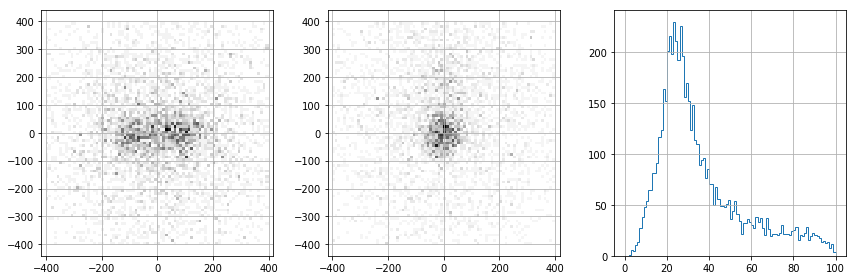

In [7]:
df = (
    inlabframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["summed"]
    .to_dataset(dim="quantity")
    .to_dataframe())

plt.figure(figsize=[12, 4])
plt.subplot(131)
plt.hist2d(
    df["px"], df["py"],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(132)
plt.hist2d(
    df["py"], df["pz"],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(133)
plt.hist(
    df["ke"],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

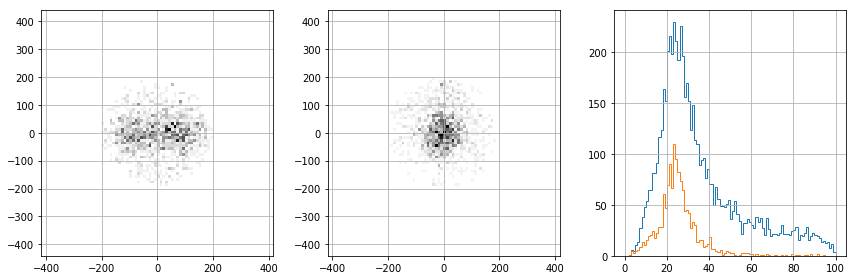

In [31]:
df = (
    inlabframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["summed"]
    .to_dataset(dim="quantity")
    .to_dataframe())
where = (
    (df["px"] ** 2 + df["py"] ** 2 + df["pz"] ** 2 < 200 ** 2)
#     (-200 < df["px"]) & (df["px"] < 200)
#     & (-100 < df["py"]) & (df["py"] < 100)
#     & (-100 < df["pz"]) & (df["pz"] < 100)
)
cond["labframe"] = where

plt.figure(figsize=[12, 4])
plt.subplot(131)
plt.hist2d(
    df["px"][where], df["py"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(132)
plt.hist2d(
    df["py"][where], df["pz"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(133)
plt.hist(
    df["ke"],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.hist(
    df["ke"][where],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

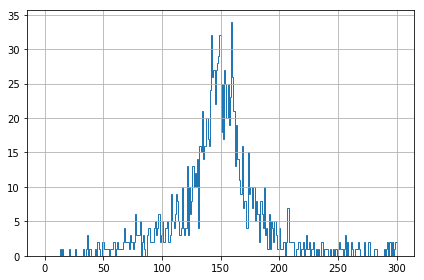

177.78659323226347

In [32]:
where = cond["labframe"]

df = (
    inlabframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["h0C1p"]
    .to_dataset(dim="quantity")
    .to_dataframe())
x = (df["px"] ** 2 + df["py"] ** 2 + df["pz"] ** 2) ** 0.5

plt.figure()
plt.hist(x[where], bins=np.linspace(0, 300, 301), histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

x.mean()

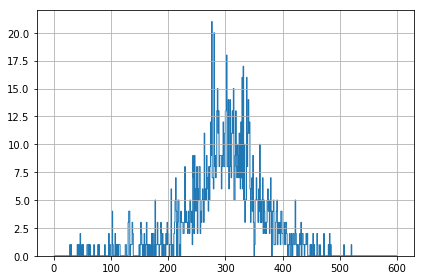

382.96769808490274

In [30]:
where = cond["labframe"]

df = (
    inlabframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["h1I2p"]
    .to_dataset(dim="quantity")
    .to_dataframe())
x = (df["px"] ** 2 + df["py"] ** 2 + df["pz"] ** 2) ** 0.5

plt.figure()
plt.hist(x[where], bins=np.linspace(0, 600, 601), histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

x.mean()

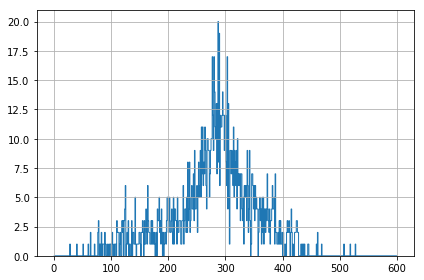

261.5765504570247

In [29]:
where = cond["labframe"]

df = (
    inlabframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["h2I1p"]
    .to_dataset(dim="quantity")
    .to_dataframe())
x = (df["px"] ** 2 + df["py"] ** 2 + df["pz"] ** 2) ** 0.5

plt.figure()
plt.hist(x[where], bins=np.linspace(0, 600, 601), histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

x.mean()

In [9]:
quan = inlabframe["quantity"].values
(n,), (m,) = inlabframe["hit"].shape, inlabframe["quantity"].shape
frame = xr.DataArray(
    n * [np.eye(m)],
    dims=["hit", "quantity", "new"],
    coords={"quantity": quan, "new": quan},
    name="frame")

x = inlabframe.loc[{"quantity": ["pz", "px", "py"]}]["h0C1p"]
# y = inlabframe.loc[{"quantity": ["pz", "px", "py"]}]["h1I2p"]
y = (inlabframe.loc[{"quantity": ["pz", "px", "py"]}]["h1I2p"]
     + inlabframe.loc[{"quantity": ["pz", "px", "py"]}]["h2I1p"])
z = xr.apply_ufunc(np.cross, x, y)

xunit = (x / (x ** 2).sum("quantity") ** 0.5).rename("xunit")
zunit = (z / (z ** 2).sum("quantity") ** 0.5).rename("zunit")
yunit = xr.apply_ufunc(np.cross, zunit, xunit).rename("yunit")

frame.loc[{"quantity": ["pz", "px", "py"], "new": "px"}] = xunit
frame.loc[{"quantity": ["pz", "px", "py"], "new": "py"}] = yunit
frame.loc[{"quantity": ["pz", "px", "py"], "new": "pz"}] = zunit

inmolframe = xr.Dataset({
    k: (inlabframe[k] * frame).sum("quantity")
    for k in ["h0C1p", "h1I2p", "h2I1p"]
}).rename({"new": "quantity"})
inmolframe["summed"] = (
    inmolframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]
    .to_array("as_")
    .sum("as_"))
inmolframe

<xarray.Dataset>
Dimensions:   (hit: 6224, quantity: 7)
Coordinates:
  * quantity  (quantity) object 't' 'x' 'y' 'pz' 'px' 'py' 'ke'
Dimensions without coordinates: hit
Data variables:
    h0C1p     (hit, quantity) float64 2.061e+03 -15.83 25.55 ... 1.066e-14 22.97
    h1I2p     (hit, quantity) float64 3.906e+03 -6.787 -9.488 ... 242.0 6.393
    h2I1p     (hit, quantity) float64 5.249e+03 0.108 2.278 ... -3.845 3.888
    summed    (hit, quantity) float64 nan nan nan 0.0 ... 0.0 62.4 238.1 33.25

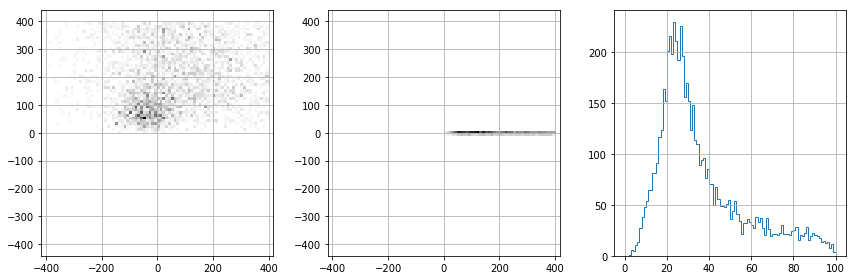

In [10]:
df = (
    inmolframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["summed"]
    .to_dataset(dim="quantity")
    .to_dataframe())

plt.figure(figsize=[12, 4])
plt.subplot(131)
plt.hist2d(
    df["px"], df["py"],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(132)
plt.hist2d(
    df["py"], df["pz"],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(133)
plt.hist(
    df["ke"],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

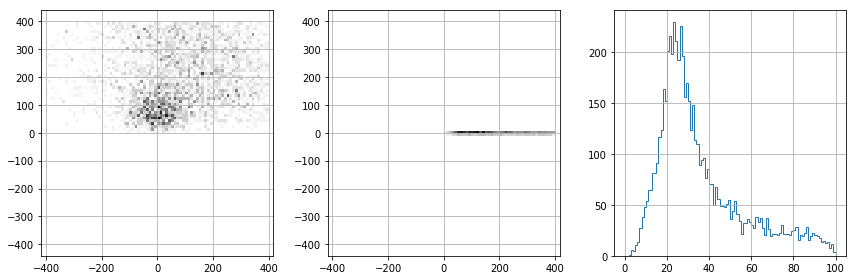

In [11]:
k = 0.8
inmolframe["weighted"] = (
    inmolframe["h0C1p"].loc[{"quantity": ["pz", "px", "py"]}] / k
    + inmolframe["h1I2p"]
    + inmolframe["h2I1p"]
)
df = pd.concat([
    (inmolframe
     .loc[{"quantity": ["pz", "px", "py"]}]["weighted"]
     .to_dataset(dim="quantity")
     .to_dataframe()),
    (inmolframe
     .loc[{"quantity": ["ke"]}]["summed"]
     .to_dataset(dim="quantity")
     .to_dataframe())
    ], axis=1)

plt.figure(figsize=[12, 4])
plt.subplot(131)
plt.hist2d(
    df["px"], df["py"],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(132)
plt.hist2d(
    df["py"], df["pz"],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(133)
plt.hist(
    df["ke"],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

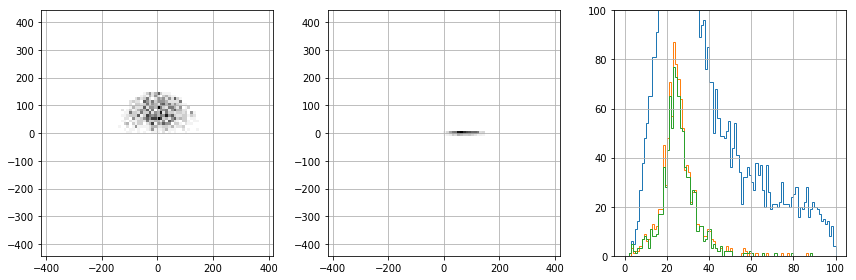

In [12]:
df["pr"] = (df["px"] ** 2 + df["py"] ** 2 + df["pz"] ** 2) ** 0.5
where = df["pr"] < 150
cond["molframe"] = where

plt.figure(figsize=[12, 4])
plt.subplot(131)
plt.hist2d(
    df["px"][where], df["py"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(132)
plt.hist2d(
    df["py"][where], df["pz"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(133)
plt.hist(
    df["ke"],
    bins=np.linspace(0, 100, 101),
    histtype="step")
where = cond["labframe"]
plt.hist(
    df["ke"][where],
    bins=np.linspace(0, 100, 101),
    histtype="step")
where = cond["molframe"]
plt.hist(
    df["ke"][where],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.grid(True)

plt.ylim(0, 100)
plt.tight_layout()
plt.show()